## Data Exploration

### Where Data come from?

This dataset is available on Kaggle, which is where our group sourced the data (https://www.kaggle.com/datasets/taweilo/mba-admission-dataset). However, the data is sourced from Wharton’s cohort profile for the Class of 2025 (https://mba.wharton.upenn.edu/class-profile/)

### What is the data about?

The dataset includes details on applicants to Wharton’s MBA program, with variables such as gender, international status, GPA, undergraduate major, race, GMAT score, years of work experience, industry, and admission status.

### When it was collected, and over what time period

The data was collected for the 2025 admissions class to UPenn’s Wharton Business School.

### How many rows and columns

6,194 Rows and 10 Columns.

### What are the types of the columns

application_id: Integer (unique identifier for each application)
gender: Object (gender of the applicant)
international: Boolean (whether the applicant is an international student)
gpa: Float (undergraduate GPA of the applicant)
major: Object (applicant's undergraduate major)
race: Object (applicant’s race)
gmat: Float (GMAT score)
work_exp: Float (years of work experience)
work_industry: Object (industry of the applicant’s work experience)
admission: Object (admission result)

### Read data and analyze data

In [4]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from collections import Counter

# Imbalanced Data

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#Ensemple

# Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# XG Boost
import xgboost as xgb


%matplotlib inline

In [5]:
# Read in data

url = 'https://raw.githubusercontent.com/toutsos/ml_project/refs/heads/main/MBA.csv'
df=pd.read_csv(url)


In [6]:
print(df.head(1))

   application_id  gender  international  gpa     major   race   gmat  \
0               1  Female          False  3.3  Business  Asian  620.0   

   work_exp       work_industry admission  
0       3.0  Financial Services     Admit  


In [7]:
print(df.describe())

       application_id          gpa         gmat     work_exp
count     6194.000000  6194.000000  6194.000000  6194.000000
mean      3097.500000     3.250714   651.092993     5.016952
std       1788.198115     0.151541    49.294883     1.032432
min          1.000000     2.650000   570.000000     1.000000
25%       1549.250000     3.150000   610.000000     4.000000
50%       3097.500000     3.250000   650.000000     5.000000
75%       4645.750000     3.350000   680.000000     6.000000
max       6194.000000     3.770000   780.000000     9.000000


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB
None


We see that after running ```df.info()``` there are features with ```Dtype = object``` that we must take care of.  

In [9]:
# Identify columns with object dtype
object_columns = df.select_dtypes(include=['object']).columns

print("Object columns:", object_columns)

df.describe(include=['object'])

Object columns: Index(['gender', 'major', 'race', 'work_industry', 'admission'], dtype='object')


,gender,major,race,work_industry,admission
count,6194,6194,4352,6194,1000
unique,2,3,5,14,2
top,Male,Humanities,White,Consulting,Admit
freq,3943,2481,1456,1619,900


## Data exploration and visualization

### Various plots that are appropiate for the data.

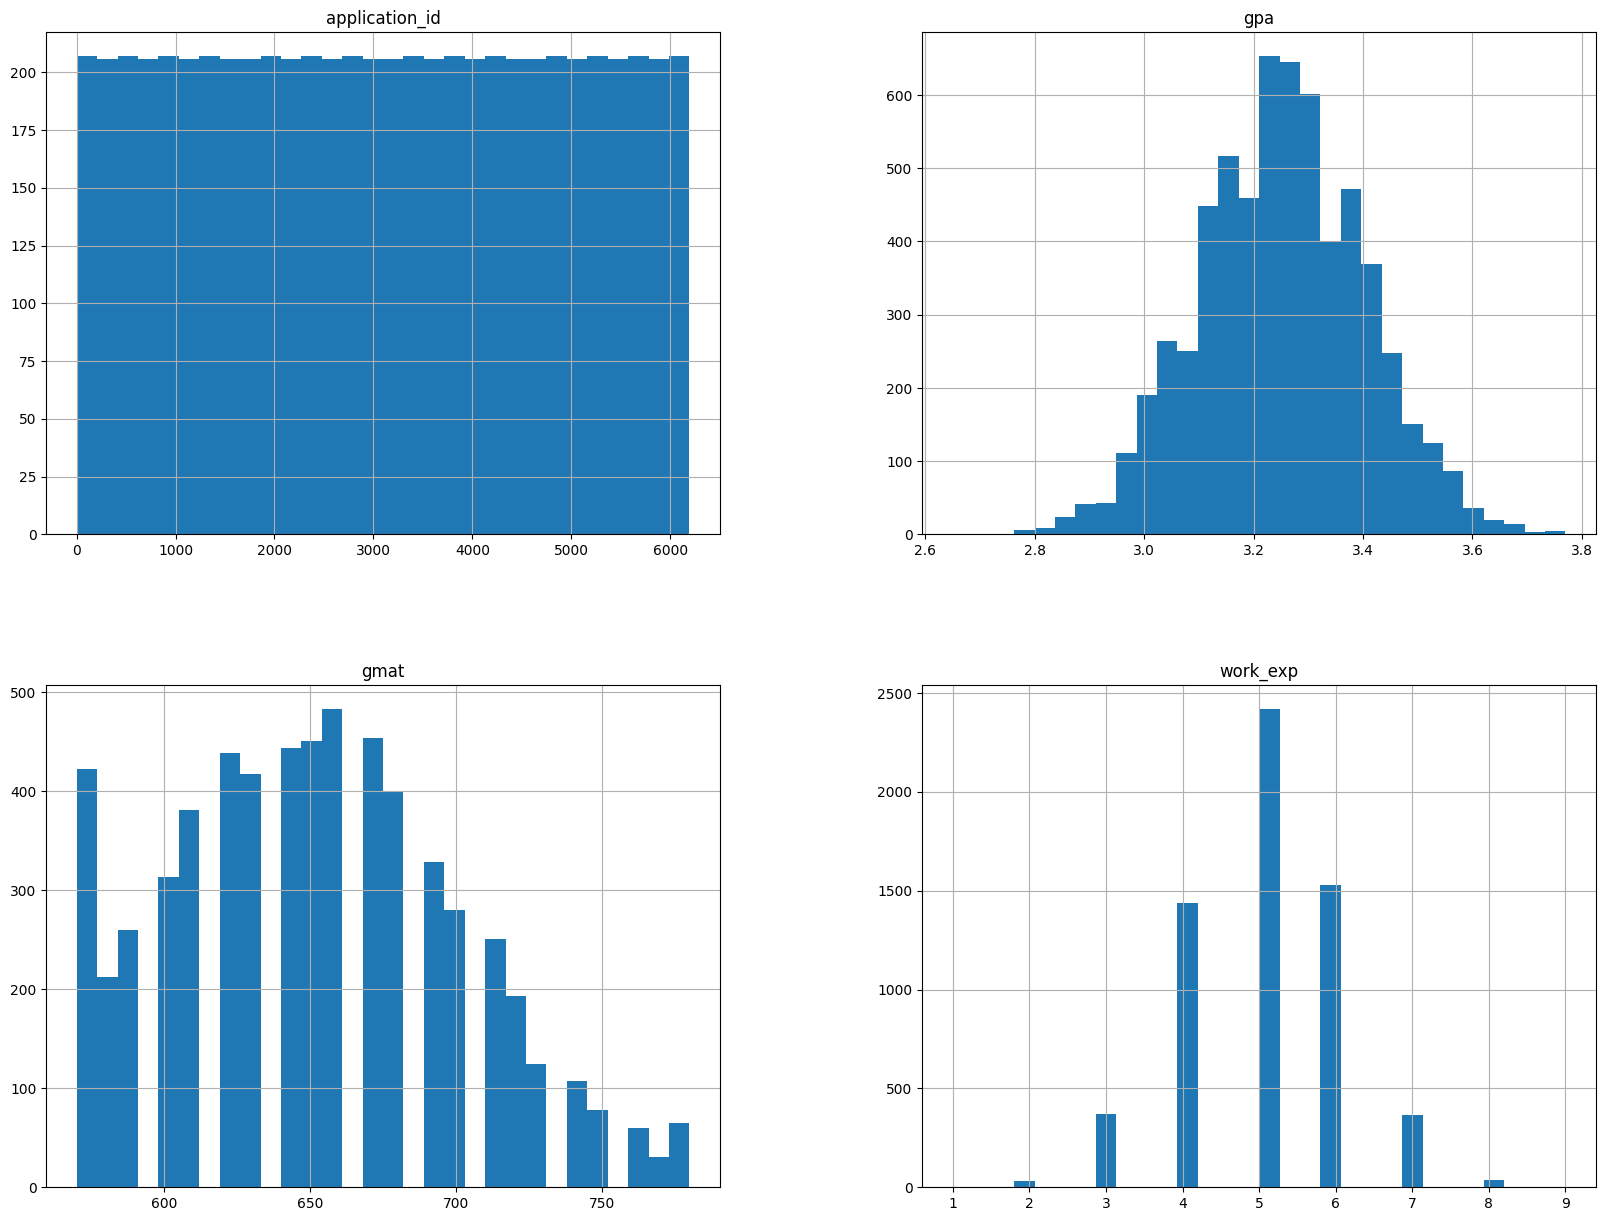

In [10]:
df.hist(bins=30, figsize=(20,15))
plt.show()

Histograms ploted only for numerical values, thats it GPA, GMAT, Work_exp and Application Id.

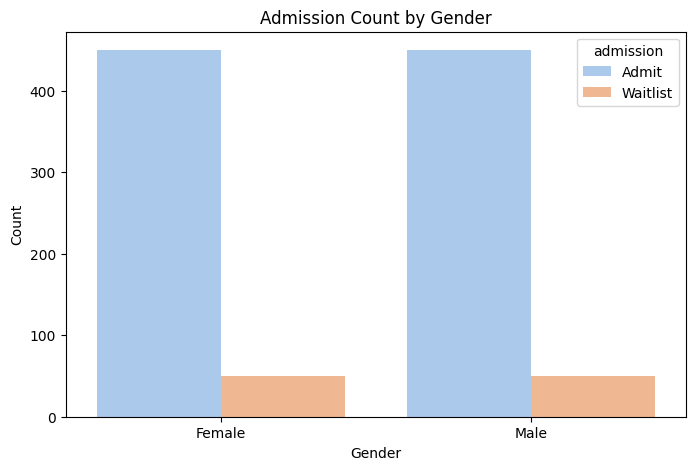

In [11]:
# Admissions based on gender

plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='admission', data=df, palette='pastel')
plt.title('Admission Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [12]:
# Prepare the admission feature for the following graphs.
df['admission'] = df['admission'].map({'Admit': 1,'Waitlist': 2 }).fillna(0)
df['admission'].value_counts()

admission
0.0    5194
1.0     900
2.0     100
Name: count, dtype: int64

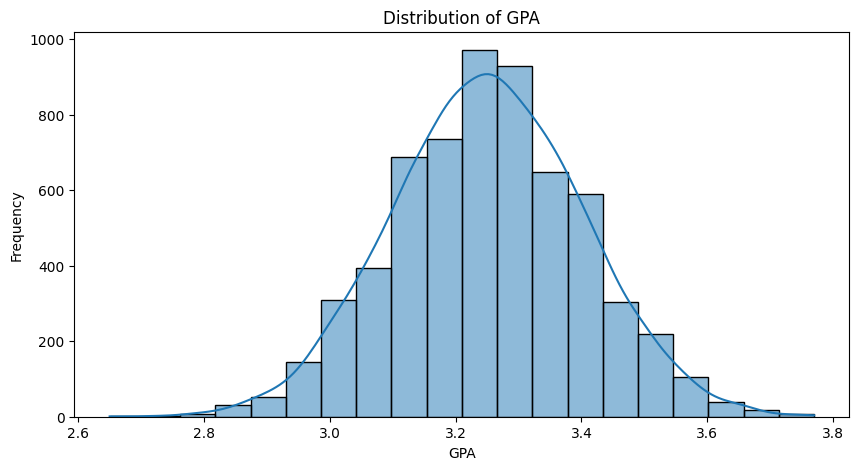

In [13]:
# GPA Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['gpa'], kde=True, bins=20)
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.show()

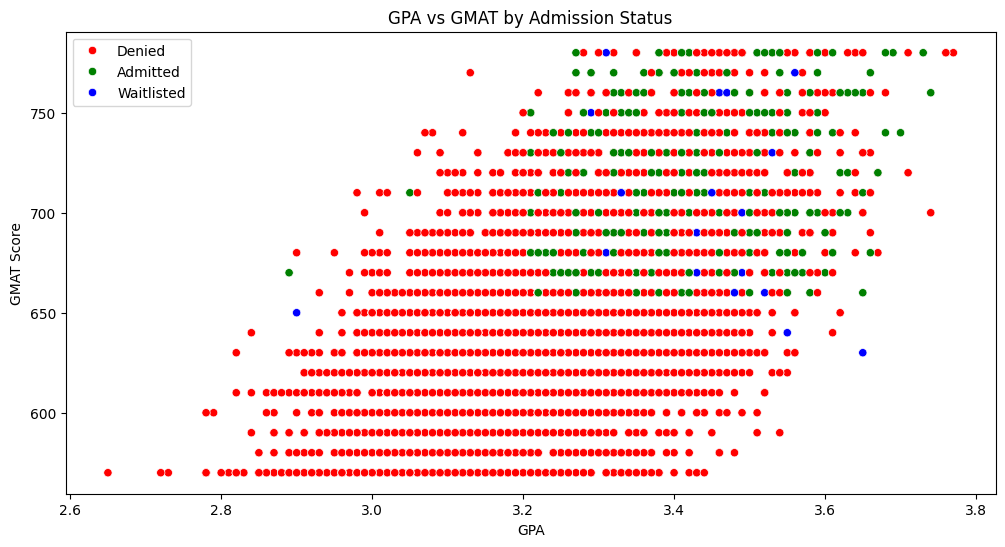

In [14]:
#GPA vs GMAT with admissions

# Custom colors for 'admission' categories
custom_palette = {0: 'red', 1: 'green', 2: 'blue'}  # Adjust colors as needed

plt.figure(figsize=(12, 6))

# Scatter plot with custom color palette
sns.scatterplot(x='gpa', y='gmat', hue='admission', data=df, palette=custom_palette)

# Customizing the legend labels
plt.legend(title='Admission Status', loc='best')

plt.title('GPA vs GMAT by Admission Status')
plt.xlabel('GPA')
plt.ylabel('GMAT Score')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Denied', 'Admitted', 'Waitlisted'])


plt.show()



- Each point in the scatter plot corresponds to a student in the dataset.
- The color of the points indicates whether the student was addmitted, waitlisted or denied.

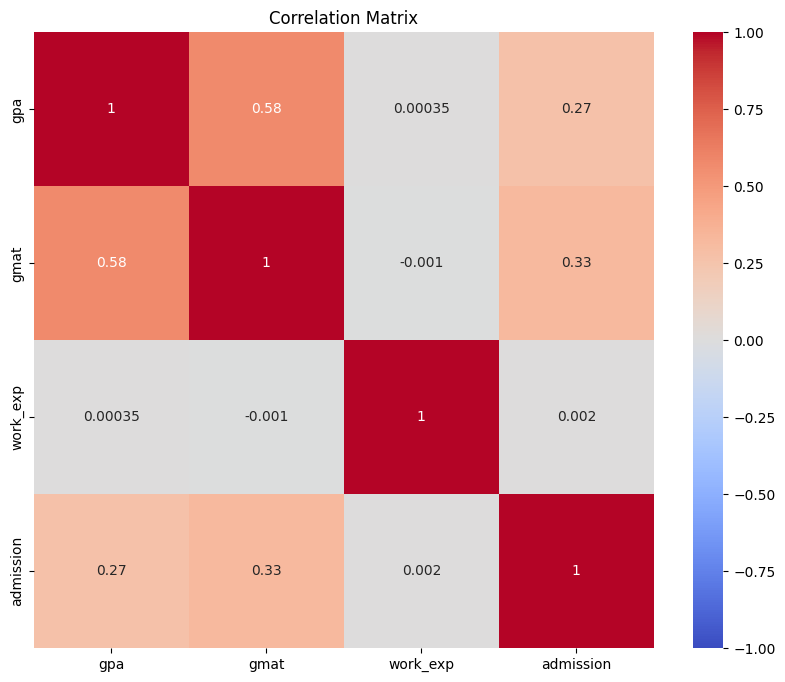

In [15]:
#heatmap
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
correlation_matrix = correlation_matrix.drop('application_id', axis=0).drop('application_id', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

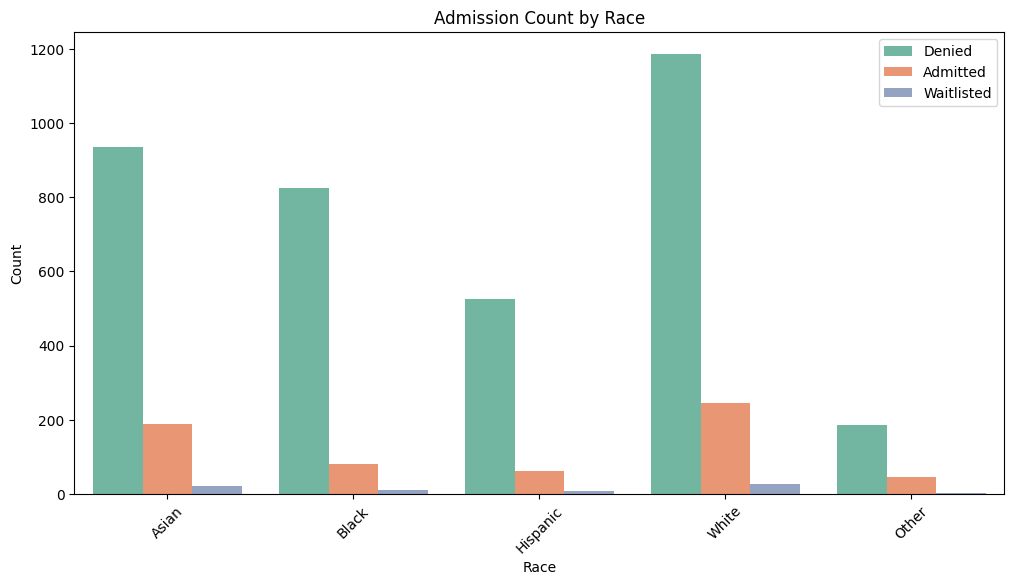

In [16]:
# Race
plt.figure(figsize=(12, 6))
sns.countplot(x='race', hue='admission', data=df, palette='Set2')
plt.title('Admission Count by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(labels=['Denied', 'Admitted', 'Waitlisted'])
plt.show()

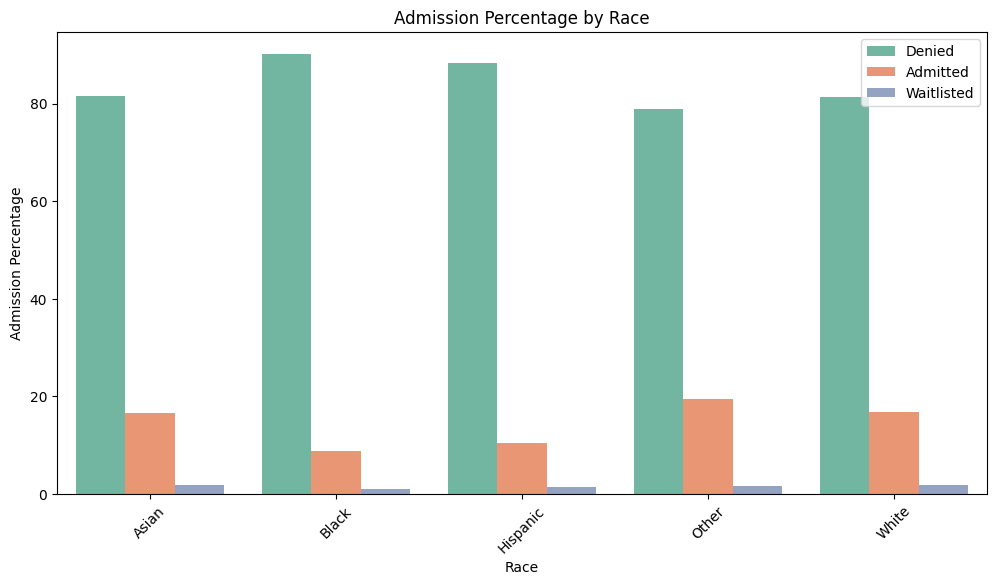

In [17]:
# Group by race and admission to get counts
admission_per_race = df.groupby(['race', 'admission']).size().reset_index(name='count')

# Calculate the total count of each race
race_total = df['race'].value_counts().reset_index(name='total_count')
race_total.columns = ['race', 'total_count']  # Rename columns to match for merging

# Merge the two dataframes on the 'race' column
admission_per_race = pd.merge(admission_per_race, race_total, on='race')

# Calculate the percentage of each admission status for each race
admission_per_race['percentage'] = (admission_per_race['count'] / admission_per_race['total_count']) * 100

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='race', y='percentage', hue='admission', data=admission_per_race, palette='Set2')

# Customize plot
plt.title('Admission Percentage by Race')
plt.xlabel('Race')
plt.ylabel('Admission Percentage')
plt.xticks(rotation=45)

# Manually set legend labels and colors
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Denied', 'Admitted', 'Waitlisted'])

plt.show()



C:\Users\micha\AppData\Local\Temp\ipykernel_29128\470129322.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=admission_by_race.index, y=admission_by_race.values, palette='Set3')


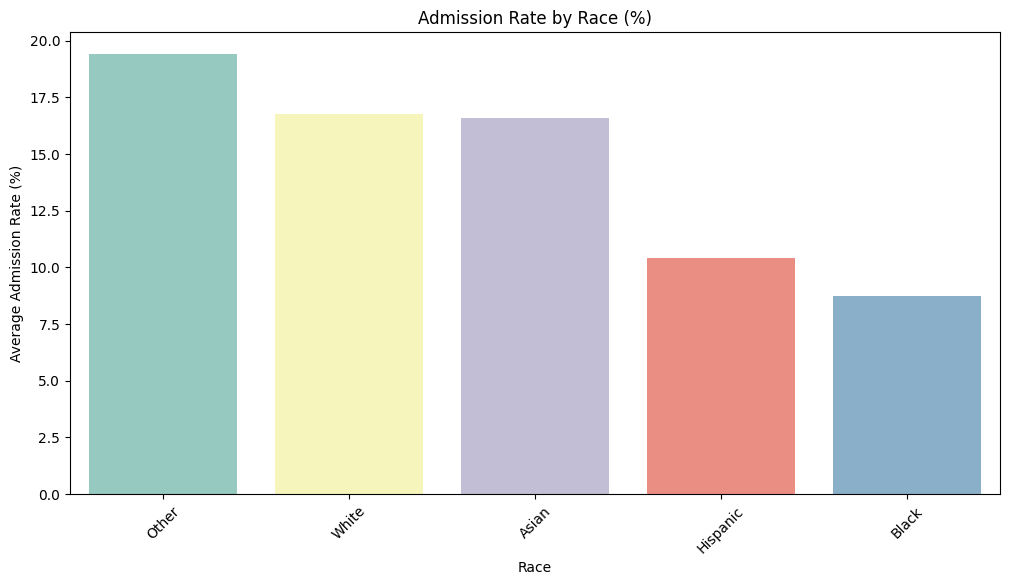

In [18]:
# Create a copy of the admission column and modify it
df['admission_temp'] = df['admission'].replace(2, 0)

# Group by race and calculate the mean of the modified admission column, then convert to percentage
admission_by_race = (df.groupby('race')['admission_temp'].mean() * 100).sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=admission_by_race.index, y=admission_by_race.values, palette='Set3')
plt.title('Admission Rate by Race (%)')
plt.xlabel('Race')
plt.ylabel('Average Admission Rate (%)')  # Note the (%) to indicate percentage
plt.xticks(rotation=45)
plt.show()

# Remove the temporary column
df.drop(columns=['admission_temp'], inplace=True)

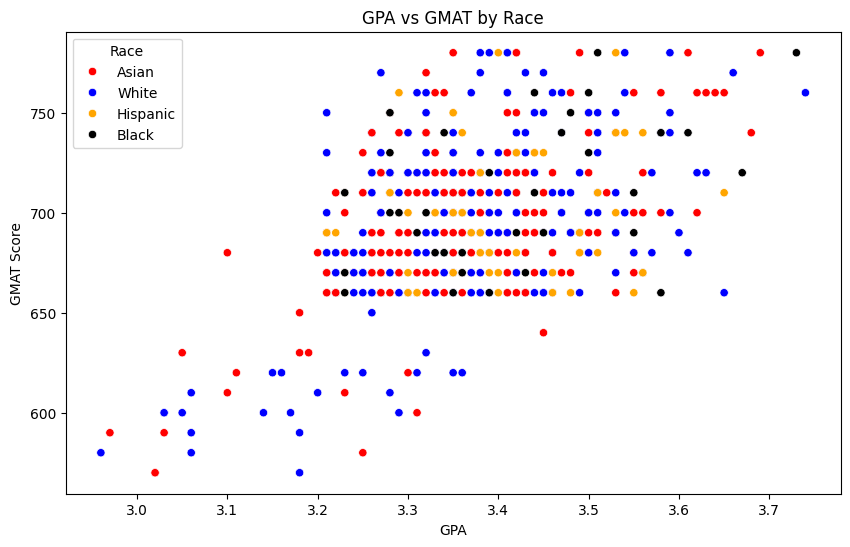

In [19]:
# Filter the dataset for the desired races
filtered_df = df[(df['admission'] == 1) & (df['race'].isin(['Black', 'Hispanic', 'White', 'Asian']))]

# Custom colors for selected races
custom_palette = {'Black': 'black', 'Hispanic': 'orange', 'White': 'blue', 'Asian': 'red'}

plt.figure(figsize=(10, 6))

# Scatter plot with custom color palette
sns.scatterplot(x='gpa', y='gmat', hue='race', data=filtered_df, palette=custom_palette)

# Customizing the legend
plt.legend(title='Race', loc='best')

# Setting the plot title and labels
plt.title('GPA vs GMAT by Race')
plt.xlabel('GPA')
plt.ylabel('GMAT Score')

plt.show()

From the above plot we can see that there is a min value on the GPA and GMAT that you need in order to be admitted as **black** and **hispanic**, while it's not the case as **white** and **asian**.   
Lets explore it a bit more.

In [20]:
# Filter for admitted values and specific races
filtered_df = df[(df['admission'] == 1) & (df['race'].isin(['Black', 'Hispanic', 'White', 'Asian']))]

# Group by race and calculate the mean GMAT and GPA scores
average_scores = filtered_df.groupby('race')[['gmat', 'gpa']].mean()

# Display the results
print(average_scores)

                gmat       gpa
race                          
Asian     694.105263  3.353895
Black     699.000000  3.380625
Hispanic  699.516129  3.397097
White     692.418033  3.358607


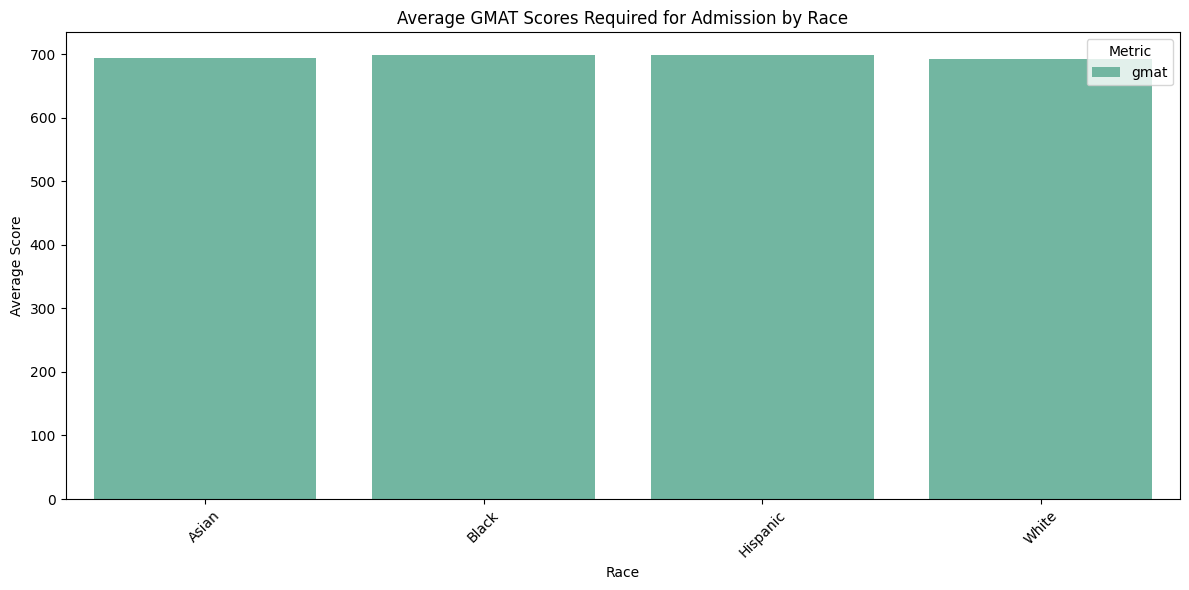

In [21]:
# Group by race and calculate the mean GMAT and GPA scores
average_scores = filtered_df.groupby('race')[['gmat']].mean().reset_index()

# Set up the plot
plt.figure(figsize=(12, 6))

# Bar plot for GMAT and GPA
sns.barplot(data=average_scores.melt(id_vars='race', var_name='Metric', value_name='Score'),
            x='race', y='Score', hue='Metric', palette='Set2')

# Customize the plot
plt.title('Average GMAT Scores Required for Admission by Race')
plt.xlabel('Race')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()

# Show the plot
plt.show()

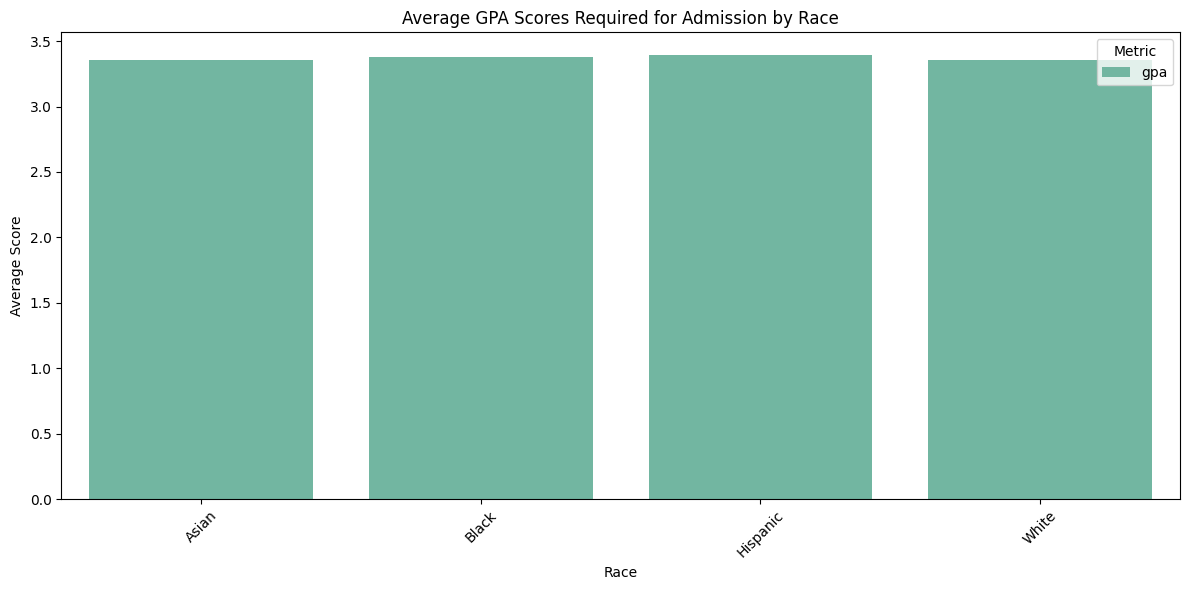

In [22]:
# Group by race and calculate the mean GMAT and GPA scores
average_scores = filtered_df.groupby('race')[['gpa']].mean().reset_index()

# Set up the plot
plt.figure(figsize=(12, 6))

# Bar plot for GMAT and GPA
sns.barplot(data=average_scores.melt(id_vars='race', var_name='Metric', value_name='Score'),
            x='race', y='Score', hue='Metric', palette='Set2')

# Customize the plot
plt.title('Average GPA Scores Required for Admission by Race')
plt.xlabel('Race')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()

# Show the plot
plt.show()

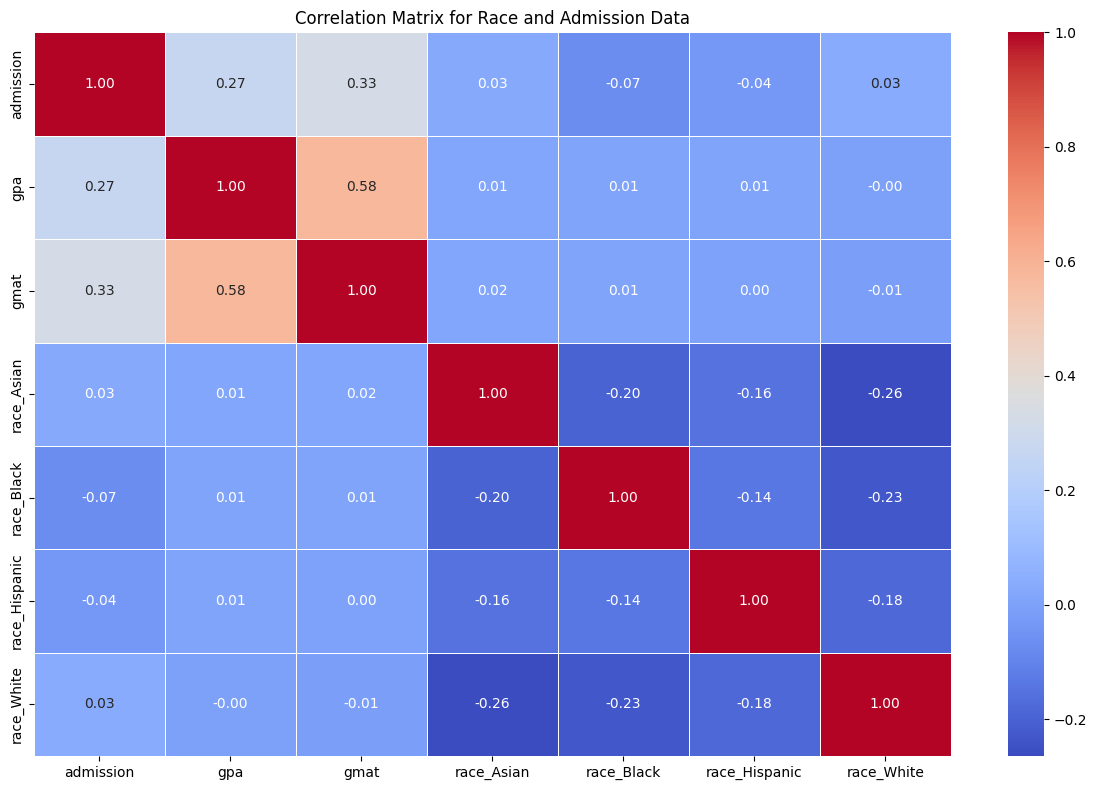

In [23]:
# Create dummy variables for the 'race' column
df_encoded = pd.get_dummies(df, columns=['race'])

# Calculate the correlation matrix
correlation_matrix = df_encoded[['admission', 'gpa', 'gmat', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_White']].corr()
# Set up the plot size
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and display the plot
plt.title('Correlation Matrix for Race and Admission Data')
plt.tight_layout()
plt.show()

Check if the Admission has any correlation with the Major Degree.

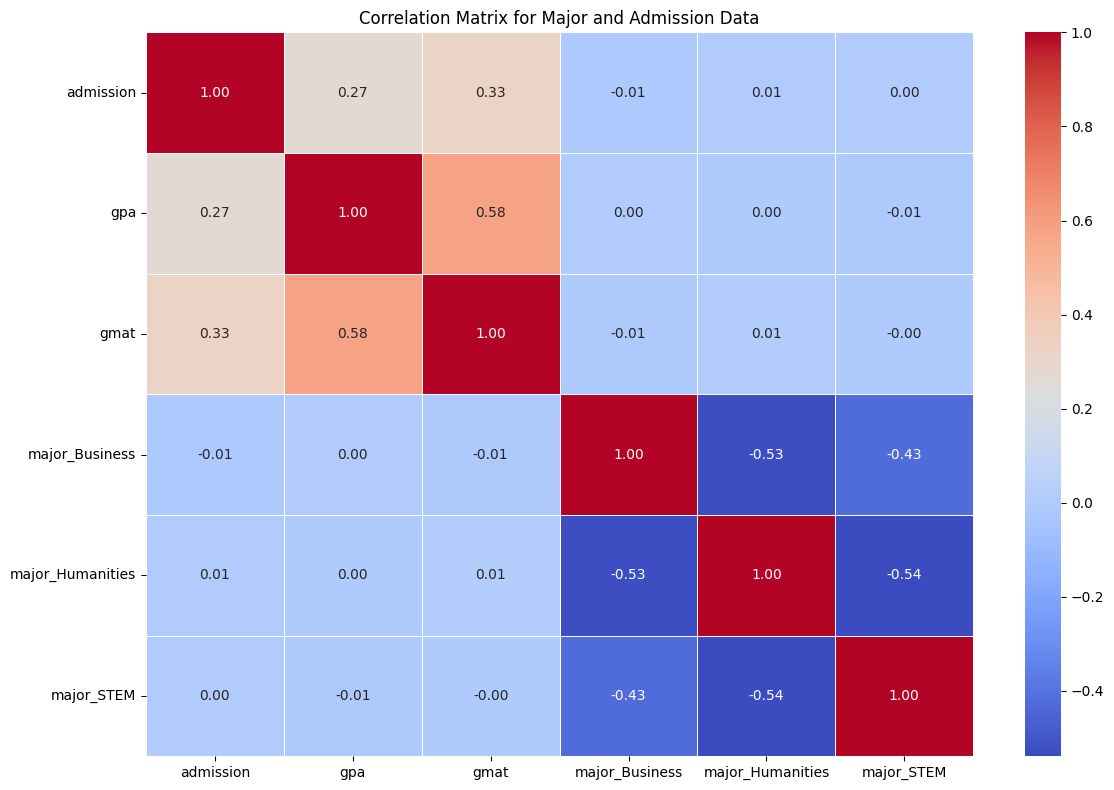

In [24]:
# Create dummy variables for the 'major' column
df_encoded = pd.get_dummies(df, columns=['major'])

# Calculate the correlation matrix
correlation_matrix = df_encoded[['admission', 'gpa', 'gmat', 'major_Business', 'major_Humanities', 'major_STEM']].corr()
# Set up the plot size
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and display the plot
plt.title('Correlation Matrix for Major and Admission Data')
plt.tight_layout()
plt.show()

Check if the admission has any correlation with the Working Industry.

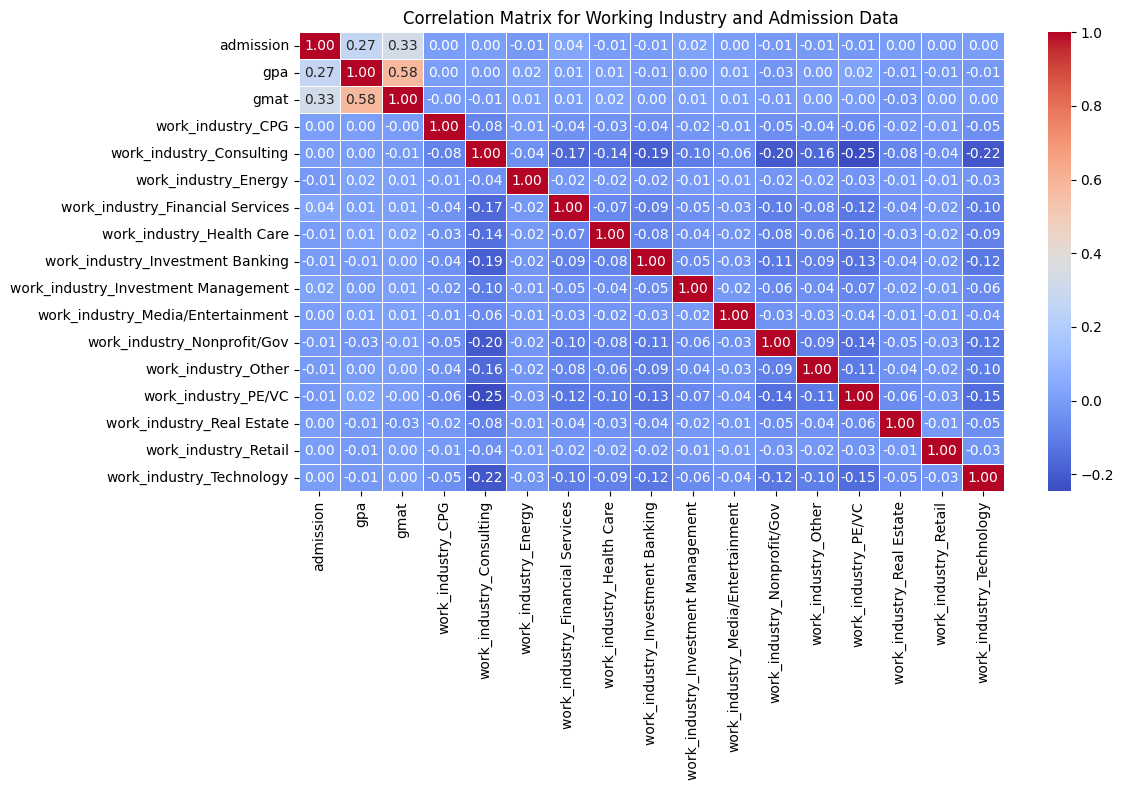

In [25]:
# Create dummy variables for the 'major' column
df_encoded = pd.get_dummies(df, columns=['work_industry'])

# Calculate the correlation matrix
correlation_matrix = df_encoded[['admission', 'gpa', 'gmat', 'work_industry_CPG', 'work_industry_Consulting', 'work_industry_Energy','work_industry_Financial Services','work_industry_Health Care', 'work_industry_Investment Banking',
       'work_industry_Investment Management',
       'work_industry_Media/Entertainment', 'work_industry_Nonprofit/Gov',
       'work_industry_Other', 'work_industry_PE/VC',
       'work_industry_Real Estate', 'work_industry_Retail',
       'work_industry_Technology']].corr()
# Set up the plot size
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and display the plot
plt.title('Correlation Matrix for Working Industry and Admission Data')
plt.tight_layout()
plt.show()

### For every plot, the question that motivated it and what you learned from it.

## Data Cleaning

### How much missing data

### What's the form of missing data?

### Where's the missing data?


In [26]:
# Count rows with missing data for each column
rows_missing_per_column = df.isnull().sum()

# Display the count of rows with missing data for each column
print("Number of rows with missing data for each column:")
print(rows_missing_per_column)

Number of rows with missing data for each column:
application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission            0
dtype: int64


### What was done about the missing data?

In [27]:
# Fill missing data
df['race'] = df['race'].fillna('Unknown')
df['admission'] = df['admission'].fillna(0)
print(df['admission'].value_counts())

admission
0.0    5194
1.0     900
2.0     100
Name: count, dtype: int64


In [28]:
# Drop unecessary features
df = df.drop(['application_id'], axis=1)
print(df.head(1))

   gender  international  gpa     major   race   gmat  work_exp  \
0  Female          False  3.3  Business  Asian  620.0       3.0   

        work_industry  admission  
0  Financial Services        1.0  


### Handle the rest Data

In [29]:
# Change Waitlisted to Denied

df.loc[df['admission'] == 2, 'admission'] = 0
print(df['admission'].value_counts())


# Apply one-hot encoding to the categorical columns
# Retrieve again the categorical columns (after handling some of them in previous steps)
object_columns = df.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

df_encoded = pd.get_dummies(df, columns=object_columns)
df_encoded = df_encoded.astype(int)
df_encoded.head()

print(df_encoded.columns)

admission
0.0    5294
1.0     900
Name: count, dtype: int64
Object columns: Index(['gender', 'major', 'race', 'work_industry'], dtype='object')
Index(['international', 'gpa', 'gmat', 'work_exp', 'admission',
       'gender_Female', 'gender_Male', 'major_Business', 'major_Humanities',
       'major_STEM', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_Unknown', 'race_White', 'work_industry_CPG',
       'work_industry_Consulting', 'work_industry_Energy',
       'work_industry_Financial Services', 'work_industry_Health Care',
       'work_industry_Investment Banking',
       'work_industry_Investment Management',
       'work_industry_Media/Entertainment', 'work_industry_Nonprofit/Gov',
       'work_industry_Other', 'work_industry_PE/VC',
       'work_industry_Real Estate', 'work_industry_Retail',
       'work_industry_Technology'],
      dtype='object')


Split and Normalize Data

In [30]:
X = df_encoded.drop(columns=['admission'])
features = X.columns
print(features)

y= df[['admission']].values

# Normalizing the data
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

Index(['international', 'gpa', 'gmat', 'work_exp', 'gender_Female',
       'gender_Male', 'major_Business', 'major_Humanities', 'major_STEM',
       'race_Asian', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_Unknown', 'race_White', 'work_industry_CPG',
       'work_industry_Consulting', 'work_industry_Energy',
       'work_industry_Financial Services', 'work_industry_Health Care',
       'work_industry_Investment Banking',
       'work_industry_Investment Management',
       'work_industry_Media/Entertainment', 'work_industry_Nonprofit/Gov',
       'work_industry_Other', 'work_industry_PE/VC',
       'work_industry_Real Estate', 'work_industry_Retail',
       'work_industry_Technology'],
      dtype='object')


## Propose ML approach

### Spliting Data for training/testing

In [31]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data (X_train and y_train)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))

print("Before SMOTE:", X_train.shape)
print("After SMOTE:", X_train_res.shape)

y_train_res = y_train_res.ravel()
print ('SMOTE Train set:', X_train_res.shape,  y_train_res.shape)




Train set: (4955, 29) (4955,)
Test set: (1239, 29) (1239,)
Before SMOTE: Counter({0.0: 4251, 1.0: 704})
After SMOTE: Counter({0.0: 4251, 1.0: 4251})
Before SMOTE: (4955, 29)
After SMOTE: (8502, 29)
SMOTE Train set: (8502, 29) (8502,)


### Why specific algorithm/s?

### Is there something about the data that has driven that decision?


### Use at least 2 algorithms per person with solid alalysis of hyperparameters.

#### Random Forest (Default Hyperparams)

Cross-validation scores: [0.82001614 0.83292978 0.82163035 0.82647296 0.83037157]
Mean accuracy: 0.8262841600592484
Precision: 0.6505
Recall: 0.5959
F1-Score: 0.6113
Accuracy of the default model: 0.8289


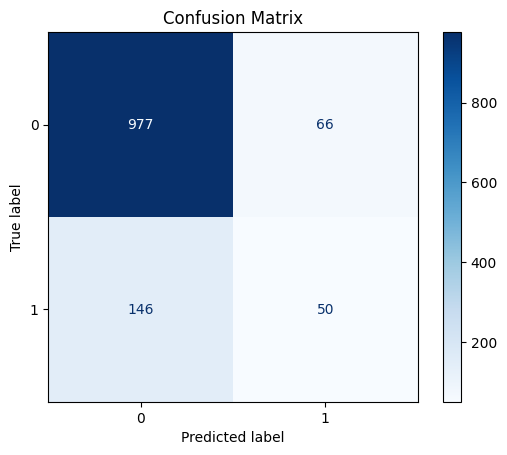



 SMOTE Results
Precision: 0.6297
Recall: 0.6054
F1-Score: 0.6148
Accuracy of the default model: 0.8136


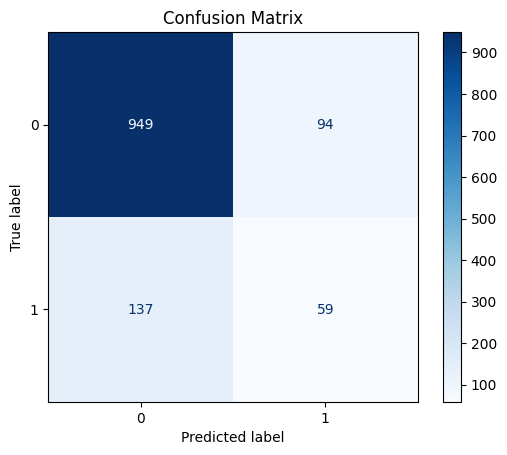

In [32]:
# Angelos:

# Random Forest
rnd_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform cross-validation
scores = cross_val_score(rnd_clf, X, y.ravel(), cv=5)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

rnd_clf.fit(X_train, y_train)

y_pred_rnd = rnd_clf.predict(X_test)

precision = precision_score(y_test, y_pred_rnd, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred_rnd, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred_rnd, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy_rnd = accuracy_score(y_test, y_pred_rnd)
print(f"Accuracy of the default model: {accuracy_rnd:.4f}")


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rnd)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ------------------------ SMOTE --------------------------
print('\n\n SMOTE Results')

# Random Forest
rnd_clf = RandomForestClassifier(random_state=42)

rnd_clf.fit(X_train_res, y_train_res)

y_pred_rnd = rnd_clf.predict(X_test)

precision = precision_score(y_test, y_pred_rnd, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred_rnd, average='macro')

print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred_rnd, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy_rnd = accuracy_score(y_test, y_pred_rnd)
print(f"Accuracy of the default model: {accuracy_rnd:.4f}") # Accuracy: 0.8111380145278451

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rnd)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()




In [33]:
# Get feature importance
feature_importances = rnd_clf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,  # Assuming X is your feature DataFrame
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                Feature  Importance
2                                  gmat    0.447821
3                              work_exp    0.152761
5                           gender_Male    0.041560
4                         gender_Female    0.037956
7                      major_Humanities    0.032799
8                            major_STEM    0.031715
6                        major_Business    0.025772
10                           race_Black    0.022011
16             work_industry_Consulting    0.021290
14                           race_White    0.016465
25                  work_industry_PE/VC    0.016170
23          work_industry_Nonprofit/Gov    0.014535
9                            race_Asian    0.013822
28             work_industry_Technology    0.013075
20     work_industry_Investment Banking    0.012699
11                        race_Hispanic    0.012258
18     work_industry_Financial Services    0.011945
24                  work_industry_Other    0.010243
1           

Tune the model:

#### Tuned Random Forest ( GridSearch )

In [34]:
param_grid = {
    'n_estimators': [100, 125, 150],      # Number of trees in the forest
    'max_depth': [15, 20, 25],     # Maximum depth of the tree
    'min_samples_split': [2, 3],     # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]       # Minimum number of samples required at a leaf node
}

rf = RandomForestClassifier(class_weight='balanced',random_state=42)

grid_search_rf = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,                 # 5-fold cross-validation
                           scoring='balanced_accuracy',   # Metric to evaluate models
                           verbose=2,            # Print progress to the console
                           n_jobs=-1)            # Use all available processors

grid_search_rf.fit(X_train, y_train.ravel())

print("Best Parameters:", grid_search_rf.best_params_)
# scoring='accuracy' {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
# scoring='balanced_accuracy' {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# ------------------- SMOTE ---------------------

print('\n\n SMOTE Results')

rf_smote = RandomForestClassifier(class_weight='balanced',random_state=42)

grid_search_rf_smote = GridSearchCV(estimator=rf_smote,
                           param_grid=param_grid,
                           cv=5,                 # 5-fold cross-validation
                           scoring='balanced_accuracy',   # Metric to evaluate models
                           verbose=2,            # Print progress to the console
                           n_jobs=-1)            # Use all available processors

grid_search_rf_smote.fit(X_train_res, y_train_res)

print("Best Parameters:", grid_search_rf_smote.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}


 SMOTE Results
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}


Train a new RandomForest with the tuned Hyperparams.

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}
Cross-validation scores: [0.71912833 0.76351897 0.77078289 0.76916868 0.75201939]
Mean accuracy: 0.7549236512326243
Precision: 0.6400
Recall: 0.7082
F1-Score: 0.6546
Accuracy with Manually Set Best Parameters: 0.7667473769168685


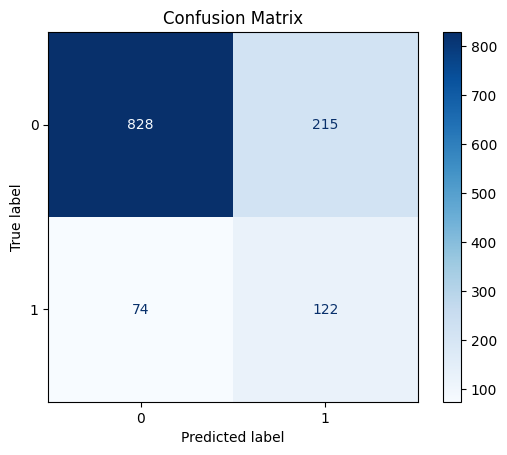



 SMOTE Results
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Precision: 0.6401
Recall: 0.6177
F1-Score: 0.6268
Accuracy with Manually Set Best Parameters: 0.8167877320419693


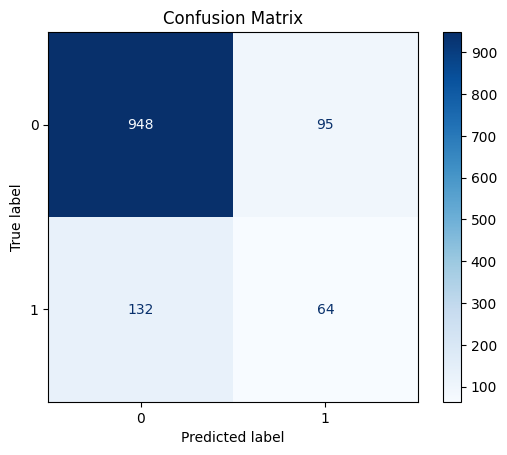

In [35]:
# Retrieve the best parameters from GridSearchCV
best_params = grid_search_rf.best_params_
print(best_params)

# Create a new model with the best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    class_weight='balanced'
)

# Perform cross-validation
scores = cross_val_score(rf_best, X, y.ravel(), cv=5)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

# Train the model
rf_best.fit(X_train, y_train.ravel())

# Evaluate on test data
y_pred = rf_best.predict(X_test)

precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Manually Set Best Parameters: {accuracy}") # 0.8159806295399515

# Compute the confusion matrix
cm = confusion_matrix(y_test.ravel(), y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# ------------------------ SMOTE --------------------------

print('\n\n SMOTE Results')

# Retrieve the best parameters from GridSearchCV
best_params = grid_search_rf_smote.best_params_
print(best_params)

# Create a new model with the best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    class_weight='balanced'
)

# Train the model
rf_best.fit(X_train_res, y_train_res)

# Evaluate on test data
y_pred = rf_best.predict(X_test)

precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Manually Set Best Parameters: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



Cross-validation scores: [0.67150928 0.69572236 0.68926554 0.7110573  0.68336026]
Mean accuracy: 0.6901829475800616
Precision: 0.6283
Recall: 0.7192
F1-Score: 0.6297
Accuracy of the default model: 0.7191


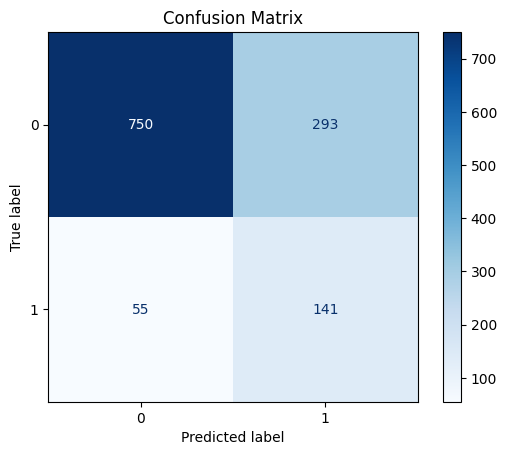

In [36]:
# Random Forest with Feature Selector.

top_n = 5
important_features = importance_df['Feature'].iloc[:top_n].tolist()

X_feat = df_encoded.drop(columns=['admission'])
X_feat = X_feat[important_features]
y_feat = df[['admission']].values

# Normalizing the data
X_feat = preprocessing.StandardScaler().fit(X_feat).transform(X_feat.astype(float))
X_train_important, X_test_important, y_train_important, y_test_important = train_test_split( X_feat, y_feat, test_size=0.2, random_state=42)

y_train_important = y_train_important.ravel()
y_test_important = y_test_important.ravel()

rnd_clf_feat = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform cross-validation
scores = cross_val_score(rnd_clf_feat, X_feat, y_feat.ravel(), cv=5)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")


rnd_clf_feat.fit(X_train_important, y_train_important)

y_pred_rnd = rnd_clf_feat.predict(X_test_important)

precision = precision_score(y_test_important, y_pred_rnd, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_important, y_pred_rnd, average='macro')

print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test_important, y_pred_rnd, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy_rnd = accuracy_score(y_test_important, y_pred_rnd)
print(f"Accuracy of the default model: {accuracy_rnd:.4f}") # Accuracy: 0.8111380145278451

# Compute the confusion matrix
cm = confusion_matrix(y_test_important, y_pred_rnd)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()




#### Gradient Boosting Classifier (optimal number of estimators)

Cross-validation scores: [0.85230024 0.84180791 0.83454399 0.8385795  0.85379645]
Mean accuracy: 0.8442056168597064
Best number of estimators: 70
Precision: 0.9236
Recall: 0.5204
F1-Score: 0.4979
Accuracy of the default model: 0.8482647296206618


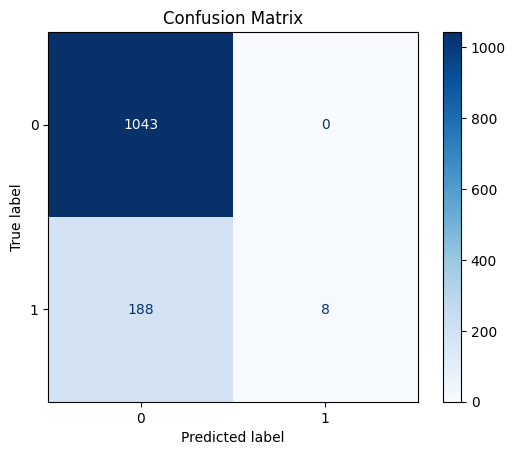

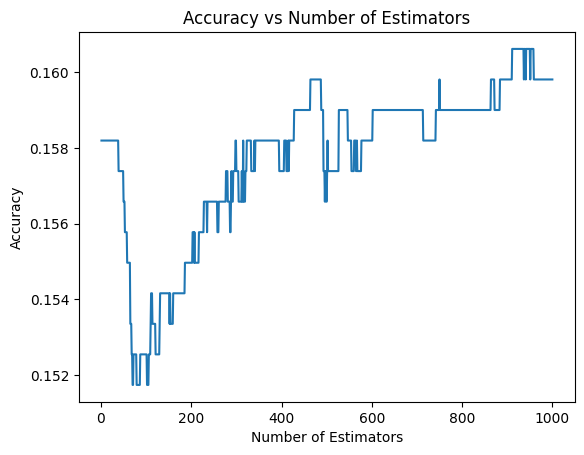



 SMOTE Results
Best number of estimators: 423
Precision: 0.6901
Recall: 0.5942
F1-Score: 0.6142
Accuracy of the default model: 0.8434221146085553


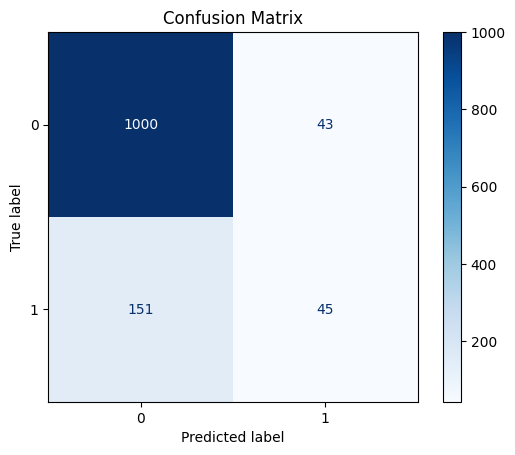

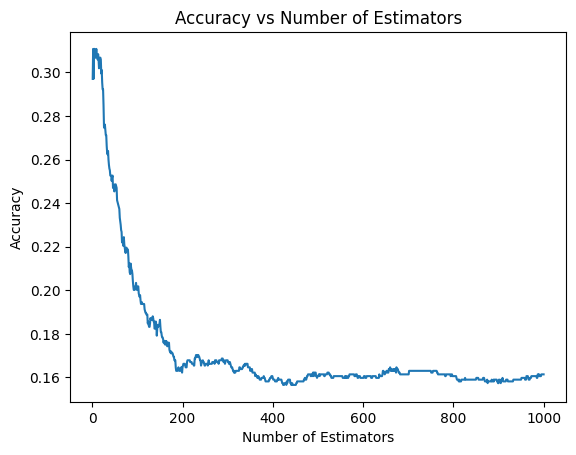

In [37]:
# GradientBoostingClassifier

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(max_depth=2, n_estimators=1000, random_state=42)

# Perform cross-validation
scores = cross_val_score(gbc, X, y.ravel(), cv=5)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

# Fit the model on the training data
gbc.fit(X_train, y_train)

# Evaluate accuracy at each stage
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbc.staged_predict(X_test)]

# Find the best number of estimators
bst_n_estemators = np.argmin(errors) + 1
print('Best number of estimators:', bst_n_estemators)

# Re-train the classifier with the optimal number of estimators
gbrt_best = GradientBoostingClassifier(max_depth = 2, n_estimators = bst_n_estemators, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred = gbrt_best.predict(X_test)

precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the default model: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


plt.plot(range(1, len(errors) + 1), errors)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.show()

# ------------------------ SMOTE --------------------------

print('\n\n SMOTE Results')

gbc = GradientBoostingClassifier(max_depth=2, n_estimators=1000, random_state=42)

# Fit the model on the training data
gbc.fit(X_train_res, y_train_res)

# Evaluate accuracy at each stage
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbc.staged_predict(X_test)]

# Find the best number of estimators
bst_n_estemators = np.argmin(errors) + 1
print('Best number of estimators:', bst_n_estemators)

# Re-train the classifier with the optimal number of estimators
gbrt_best = GradientBoostingClassifier(max_depth = 2, n_estimators = bst_n_estemators, random_state=42)
gbrt_best.fit(X_train_res, y_train_res)

y_pred = gbrt_best.predict(X_test)

precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the default model: {accuracy}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


plt.plot(range(1, len(errors) + 1), errors)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.show()



#### XG Boost

In [38]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [1.0],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train, y_train)
xgb_model = grid_search.best_estimator_

grid_search_SMOTE = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search_SMOTE.fit(X_train_res, y_train_res)
xgb_model_SMOTE = grid_search_SMOTE.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1.0}
Cross-validation scores: [0.81678773 0.81678773 0.82808717 0.81033091 0.82229402]
Mean accuracy: 0.8188575131594217
Precision: 0.8515
Recall: 0.5148
F1-Score: 0.4876
Accuracy: 0.8458


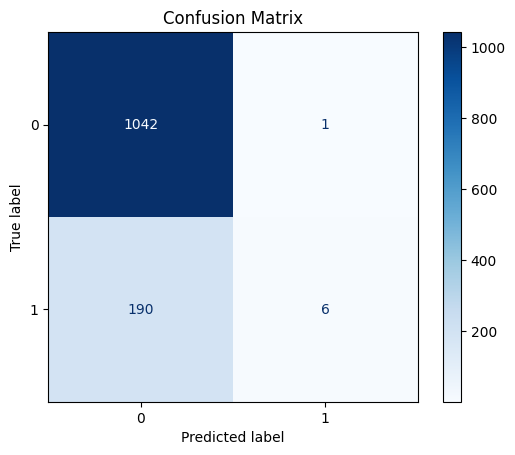

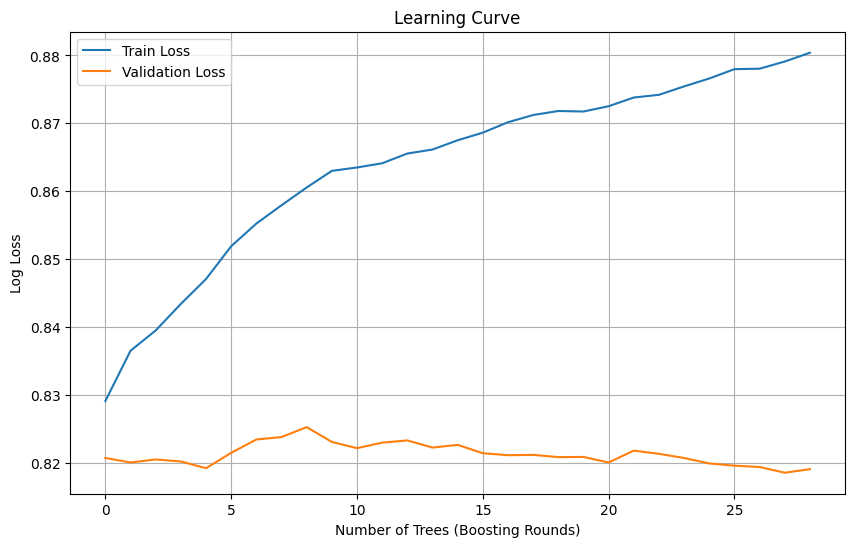



 SMOTE Results
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1.0}
Precision: 0.6574
Recall: 0.7184
F1-Score: 0.6750
Accuracy: 0.7910


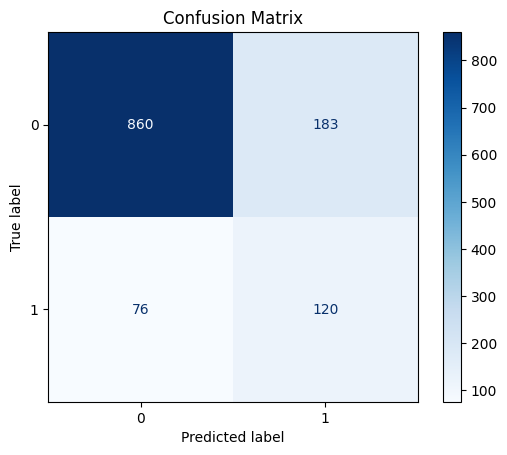

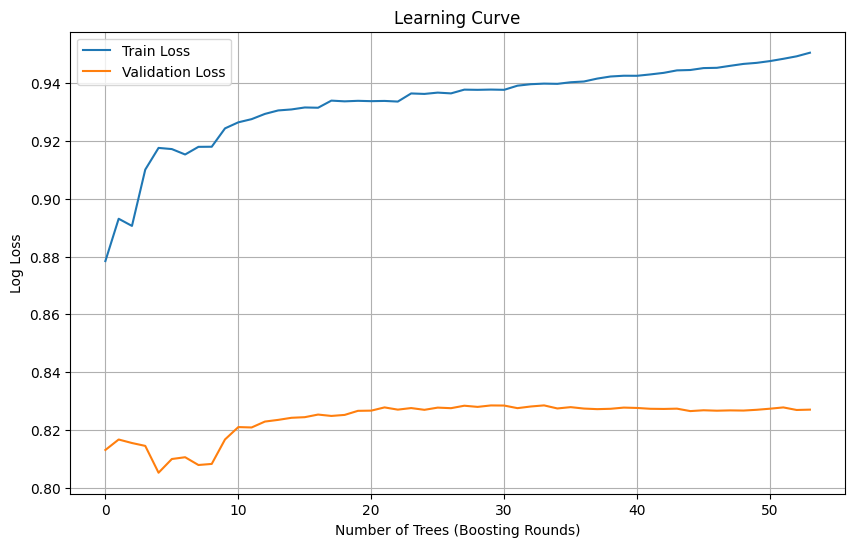

In [39]:
print("Best Parameters:", grid_search.best_params_)

# Perform cross-validation
scores = cross_val_score(xgb_model, X, y.ravel(), cv=5)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

xgb_model.set_params(eval_metric='auc')
xgb_model.set_params(early_stopping_rounds=20)

# Fit the model on the training data
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False              # Suppress detailed output
)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance metrics
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Get the results of the evaluation
results = xgb_model.evals_result()

# Extract the training and validation losses
train_loss = results['validation_0']['auc']
test_loss = results['validation_1']['auc']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Number of Trees (Boosting Rounds)')
plt.ylabel('Log Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


#-------------------------------- SMOTE ------------------------------------

print('\n\n SMOTE Results')

print("Best Parameters:", grid_search_SMOTE.best_params_)

xgb_model_SMOTE.set_params(eval_metric='auc')
xgb_model_SMOTE.set_params(early_stopping_rounds=20)

# Fit the model on the training data
xgb_model_SMOTE.fit(
    X_train_res, y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_test, y_test)],
    verbose=False              # Suppress detailed output
)


# Make predictions
y_pred = xgb_model_SMOTE.predict(X_test)

# Evaluate performance metrics
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Get the results of the evaluation
results = xgb_model_SMOTE.evals_result()

# Extract the training and validation losses
train_loss = results['validation_0']['auc']
test_loss = results['validation_1']['auc']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('Number of Trees (Boosting Rounds)')
plt.ylabel('Log Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
from sklearn.utils import resample

# Separate the dataset into subsets by class
class_0 = df_encoded[df_encoded['admission'] == 0]  # Class 0
class_1 = df_encoded[df_encoded['admission'] == 1]  # Class 1

print('Class 0 shape:', class_0.shape)
print('Class 1 shape:', class_1.shape)

# Find the size of the smallest class
min_size = min(len(class_0), len(class_1))

# Downsample all classes to match the smallest class size
class_0_downsampled = resample(class_0, replace=False, n_samples=min_size, random_state=42)
class_1_downsampled = resample(class_1, replace=False, n_samples=min_size, random_state=42)


# Combine the downsampled classes into one balanced dataset
df_balanced = pd.concat([class_0_downsampled, class_1_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the class distribution
print(df_balanced['admission'].value_counts())

X_balanced = df_balanced.drop(columns=['admission'])

y_balanced = df_balanced['admission']  # Target column

# Normalizing the data
X_resample = preprocessing.StandardScaler().fit(X_balanced).transform(X_balanced.astype(float))

X_train_resample, X_test_resample, y_train_resample, y_test_resample = train_test_split( X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [25, 30, 35, 50],       # Number of trees in the forest
    'max_depth': [7, 8, 10, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 3, 5],       # Valid values (>= 2)
    'min_samples_leaf': [2, 3]            # Minimum number of samples required at a leaf node
}

# Initialize the Random Forest model
model_res = RandomForestClassifier(random_state=42)

grid_search_rf_res = GridSearchCV(estimator=model_res,
                           param_grid=param_grid,
                           cv=5,                 # 5-fold cross-validation
                           scoring='accuracy',   # Metric to evaluate models
                           verbose=2,            # Print progress to the console
                           n_jobs=-1)            # Use all available processors

grid_search_rf_res.fit(X_train_resample, y_train_resample)

print("Best Parameters:", grid_search_rf_res.best_params_)


# Now perform cross-validation to get all the metrics
# cross_validate can return multiple scoring metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

cv_results = cross_validate(grid_search_rf_res.best_estimator_, X_train_resample, y_train_resample,
                            cv=5, scoring=scoring, return_train_score=False)

# Print cross-validation results for each metric
print(f"\nCross-validation results:\n")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f} ± {np.std(cv_results['test_accuracy']):.4f}")
print(f"Precision (macro): {np.mean(cv_results['test_precision_macro']):.4f} ± {np.std(cv_results['test_precision_macro']):.4f}")
print(f"Recall (macro): {np.mean(cv_results['test_recall_macro']):.4f} ± {np.std(cv_results['test_recall_macro']):.4f}")
print(f"F1-Score (macro): {np.mean(cv_results['test_f1_macro']):.4f} ± {np.std(cv_results['test_f1_macro']):.4f}")

# Now, use the best model from GridSearchCV to predict on the test set
y_pred_test = grid_search_rf_res.best_estimator_.predict(X_test_resample)

# Evaluate the model on the test set
precision_test = precision_score(y_test_resample, y_pred_test, average='macro')
print(f"\nTest Precision: {precision_test:.4f}")

recall_test = recall_score(y_test_resample, y_pred_test, average='macro')
print(f"Test Recall: {recall_test:.4f}")

f1_test = f1_score(y_test_resample, y_pred_test, average='macro')
print(f"Test F1-Score: {f1_test:.4f}")

accuracy_test = accuracy_score(y_test_resample, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test_resample, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



Class 0 shape: (5294, 30)
Class 1 shape: (900, 30)
admission
1    900
0    900
Name: count, dtype: int64


ValueError: Found input variables with inconsistent numbers of samples: [1800, 6194]

## Linear Regression

In [41]:
# Assuming df_encoded is your preprocessed DataFrame
X = df_encoded.drop(columns=['admission'])  # Drop the target column
y = df_encoded['admission']                # Extract the target column

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')  # Handle imbalance
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1043
           1       0.35      0.73      0.48       196

    accuracy                           0.74      1239
   macro avg       0.64      0.74      0.65      1239
weighted avg       0.84      0.74      0.77      1239

[[778 265]
 [ 52 144]]


In [46]:
importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
print(importance.sort_values(by='Coefficient', ascending=False))

                                Feature  Coefficient
2                                  gmat     1.305963
4                         gender_Female     0.259352
12                           race_Other     0.130183
18     work_industry_Financial Services     0.116684
14                           race_White     0.115072
21  work_industry_Investment Management     0.085128
9                            race_Asian     0.084876
26            work_industry_Real Estate     0.076495
6                        major_Business     0.036393
1                                   gpa     0.034166
28             work_industry_Technology     0.030246
23          work_industry_Nonprofit/Gov     0.029991
3                              work_exp     0.028263
0                         international     0.027845
13                         race_Unknown     0.027845
15                    work_industry_CPG     0.001403
8                            major_STEM    -0.001393
16             work_industry_Consulting    -0.

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1, 'penalty': 'l1'}


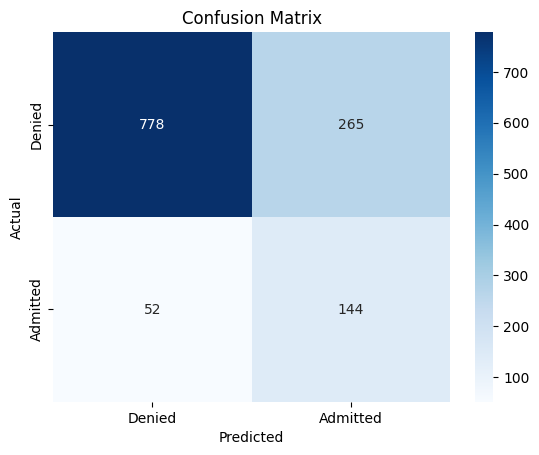

In [49]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plot the confusion matrix
cm = [[778, 265], [52, 144]]  # Replace with your confusion matrix values
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Denied', 'Admitted'], yticklabels=['Denied', 'Admitted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

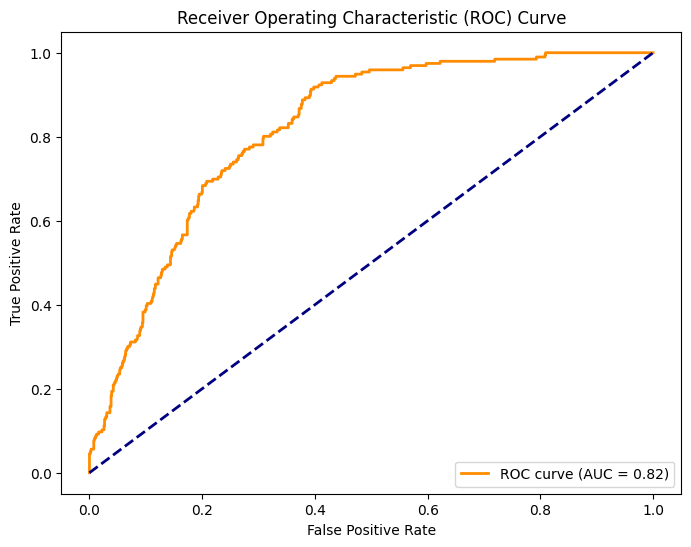

In [51]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Evaluate Performance

### Why specific metric?

### Are there alternatives?

### Use at least 2 metrics with solid explanation and performance under that metric.

## Present Results.

### Visualize the results.

### Explain plots and results carefully.

### Provide evidence of the results supporting or not supporting the goal.

### Touth on all components in the data science process.

### Did we achieve our goal?

### What we could have done better?

### What else could we do?

### What would be most impactful next step and why?

## Final Report.

### Turn in code and report document (word/pdf).

### Each people should highlight its contribution.